In [1]:
%pip install graphviz
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
class Value:
    def __init__(self,data,_children=(),_op='',label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data+other.data, (self,other),_op='+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
        
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),_op='*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
        
    def __truediv__(self,other):
        return Value(self.data / other.data, (self,other),_op='/')
        
    def __sub__(self,other):
        return Value(self.data - other.data, (self,other),_op='-')
    
    def tanh(self):
        x=self.data
        t = (np.exp(2*x)-1)/(np.exp(2*x)+1)
        out = Value(t, (self, ), label='tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out  
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    

In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s |  data %4f | grad %4f }" % (n.label,n.data,n.grad), shape='record')
        # if this value is a result of some operation, create an op node for it
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
    

In [4]:
#Backpropagation in Neuron 

x1 = Value(1.0,label='w1')
x2 = Value(0.0,label='w2')

#  weights w1,w2
w1 = Value(2.0,label='w1')
w2 = Value(-1.0,label='w2')

#bias 
b=Value(2.2,label='b')

x1w1 = x1*w1 ;x1w1.label = 'x1*w1'
x2w2 = x2*w2 ;x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'

n=x1w1x2w2+b; n.label='n'
o=n.tanh();o.label='o'


o.backward()




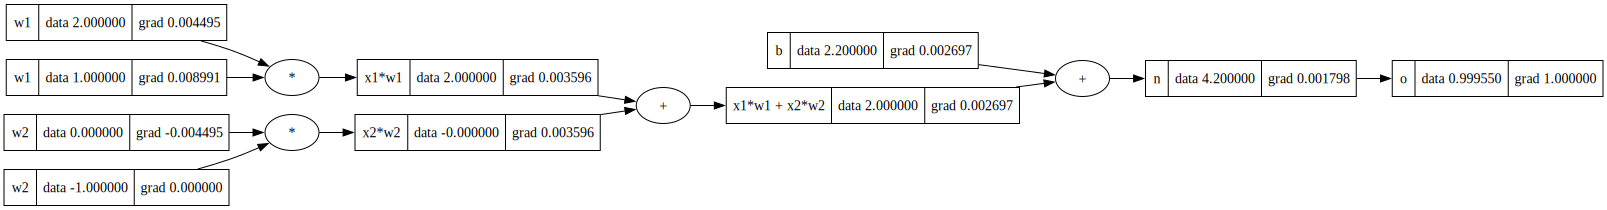

In [5]:
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# # x1._backward()
# # w1._backward()
# # x2._backward()
# # w2._backward()
o.backward()
draw_dot(o)